In [ ]:
pip install gdal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyproj import Transformer

# Define the source (Projected CRS) and target (Geographic CRS)
source_crs = "EPSG:32643"  # Example: UTM Zone 43N
target_crs = "EPSG:4326"   # WGS 84 (Lat/Lon)

# Initialize Transformer
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Given UTM coordinates
utm_x, utm_y = 773694.7, 1433151.1

# Convert to Latitude, Longitude
lon, lat = transformer.transform(utm_x, utm_y)

print(f"Latitude: {lat}, Longitude: {lon}")


Latitude: 12.951750648647224, Longitude: 77.52267082073605


In [ ]:
!pip install gdal

vector to raster conversion


In [ ]:
from osgeo import gdal, ogr

#paths to the vector and raster files
vector_file = '/content/drive/MyDrive/Bang_Part/Bengaluru_Part.shp'  # Ensure this file is in the correct path
output_raster = '/content/drive/MyDrive/Bang_Part/Bengaluru_Part2.tif'  # Output raster file
pixel_size = 0.6  # (check info in qgis )
no_data_value = 0  # Background value
vector_ds = ogr.Open(vector_file)
layer = vector_ds.GetLayer()

#x_min, x_max, y_min, y_max = layer.GetExtent()
x_min, x_max, y_min, y_max = 777729.3930981999728829,781027.6866934000281617,1427441.4396319999359548 ,1435310.0054311999119818 #manually assigned them pased on *.tif file
print(x_min,x_max, y_min, y_max) #debugging
x_res = int((x_max - x_min) / pixel_size) #width
y_res = int((y_max - y_min) / pixel_size) #height
print(x_res,y_res)
driver = gdal.GetDriverByName("GTiff")
raster_ds = driver.Create(output_raster, x_res, y_res, 1, gdal.GDT_Byte)


raster_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size)) #position
print(layer)  #debugging purpose

raster_ds.SetProjection(layer.GetSpatialRef().ExportToWkt()) #Set projection (same as vector file)

#  Rasterize only the **XY** part of MultiPolygonZ (ignoring Z)
gdal.RasterizeLayer(raster_ds, [1], layer, burn_values=[1])  # 1 White pixels
raster_ds = None
vector_ds = None #close the raster and vector ds

print(f"✅ Raster file saved as: {output_raster}")


AttributeError: 'NoneType' object has no attribute 'GetLayer'

In [ ]:
pip install rasterio

In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np

# Define file paths for the pansharpened image and building footprint file
hr_file = '/content/drive/MyDrive/Bang_Part/bang_rastor_clipped.tif'      # High-resolution pansharpened image
bf_file = '/content/drive/MyDrive/Bang_Part/Bengaluru_Part2.tif'       # Building footprint image (0 for no building, 1 for building)

# Open both files
with rasterio.open(hr_file) as hr_src, rasterio.open(bf_file) as bf_src:

    width, height = hr_src.width, hr_src.height
    print(f"Raster dimensions: {width} x {height}")


    n_cols = width // 128
    n_rows = height // 128
    print(f"Number of patches: {n_rows} rows x {n_cols} cols = {n_rows*n_cols}")

    hr_snippets = []
    bf_snippets = []

    # Loop over the raster using non-overlapping windows
    for i in range(n_rows):
        for j in range(n_cols):
            # Define a 128x128 window starting at (j*128, i*128)
            window = Window(j * 128, i * 128, 128, 128)

            # Read the window from each raster
            # hr_patch shape: (bands, 128, 128) – e.g., 3 bands for RGB or more
            hr_patch = hr_src.read(window=window)
            bf_patch = bf_src.read(window=window)

            hr_snippets.append(hr_patch)
            bf_snippets.append(bf_patch)

    # Convert lists to numpy arrays
    # The resulting shape will be (num_patches, bands, 128, 128)
    hr_snippets = np.array(hr_snippets)
    bf_snippets = np.array(bf_snippets)

    print("HR snippets array shape:", hr_snippets.shape)
    print("Building footprint snippets array shape:", bf_snippets.shape)

Raster dimensions: 5496 x 13113
Number of patches: 102 rows x 42 cols = 4284
HR snippets array shape: (4284, 3, 128, 128)
Building footprint snippets array shape: (4284, 1, 128, 128)


CHECK IMAGES

In [ ]:
print("HR snippets array shape:", hr_snippets.shape)
print("Building footprint snippets array shape:", bf_snippets.shape)


HR snippets array shape: (4284, 3, 128, 128)
Building footprint snippets array shape: (4284, 1, 128, 128)


856


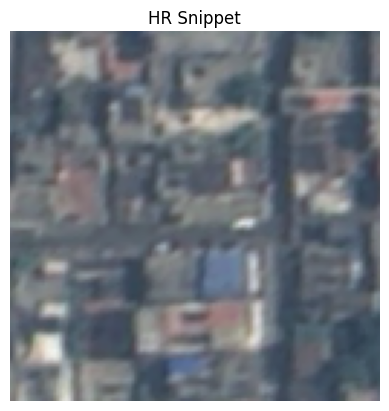

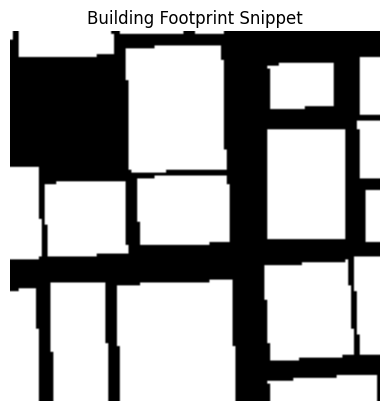

In [ ]:
import matplotlib.pyplot as plt
num=int(input())
#for high resolution data
hr = hr_snippets[num]  # shape: (bands, 128, 128)
if hr.shape[0] >= 3: #3 for RGB
    rgb_img = hr[:3].transpose(1, 2, 0)  # Convert from (RGB(3 bands), 128, 128) to (128, 128, 3)
    plt.imshow(rgb_img)
else:
    plt.imshow(hr[num], cmap='gray')
plt.title("HR Snippet")
plt.axis('off')
plt.show()

# Display the Building Footprint snippet
bf = bf_snippets[num]  # shape: (bands, 128, 128)
# If it's a single channel image, display as grayscale
if bf.shape[0] == 1:
    plt.imshow(bf[0], cmap='gray')
else:
    # If multiple channels, assume RGB
    rgb_img = bf[:3].transpose(1, 2, 0)
    plt.imshow(rgb_img)
plt.title("Building Footprint Snippet")
plt.axis('off')
plt.show()

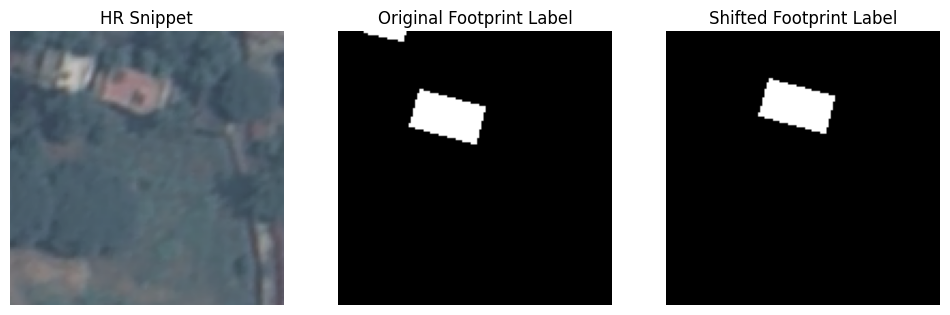

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
# Define shift values
shift_right = 10 # Move right by 5 pixels
shift_up = -5    # Move up by 5 pixels (negative for upward shift)

# Function to shift the image
def shift_label(label, shift_right, shift_up):
    return shift(label, shift=[0, shift_up, shift_right], mode='nearest')

# Select an index to visualize
index = 2232


# Get HR and original label
hr_sample = hr_snippets[index]
bf_sample = bf_snippets[index]

# Shift the building footprint label
shifted_label = shift_label(bf_sample, shift_right, shift_up)

# Plot the original vs. shifted labels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# HR image
if hr_sample.shape[0] >= 3:
    axes[0].imshow(hr_sample[:3].transpose(1, 2, 0))  # RGB format
else:
    axes[0].imshow(hr_sample[0], cmap='gray')
axes[0].set_title("HR Snippet")
axes[0].axis("off")

# Original label
axes[1].imshow(bf_sample[0], cmap="gray")
axes[1].set_title("Original Footprint Label")
axes[1].axis("off")

# Shifted label
axes[2].imshow(shifted_label[0], cmap="gray")
axes[2].set_title("Shifted Footprint Label")
axes[2].axis("off")

plt.show()


shift by 9 right and 5 top (-ve)

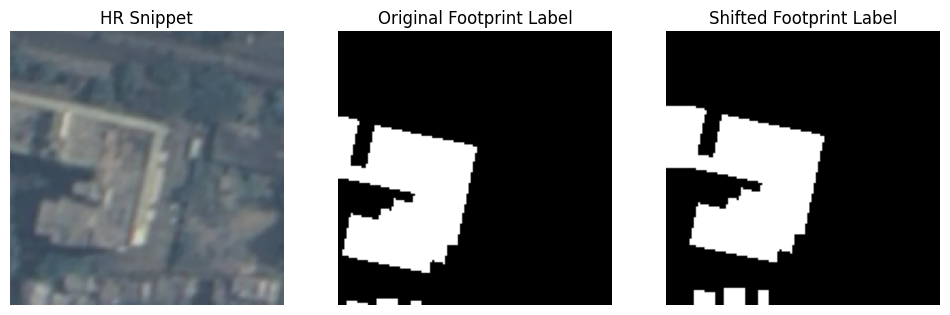

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift


shift_right = 9  #  right by 10 pixels
shift_up = -5     # up by 5 pixels (-ve for up)

def shift_label(label, shift_right, shift_up):
    return shift(label, shift=[0, shift_up, shift_right], mode='nearest')

shifted_bf_snippets = np.array([shift_label(bf, shift_right, shift_up) for bf in bf_snippets])

index = 2999

# Get HR image and shifted footprint label
hr_sample = hr_snippets[index]
bf_sample = bf_snippets[index]  # Original footprint
shifted_label = shifted_bf_snippets[index]  # Shifted footprint
# Replace bf_snippets with the shifted images
#bf_snippets = shifted_bf_snippets #shifted is the same as bf_snippets


# Plot the original vs. shifted labels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# HR image
if hr_sample.shape[0] >= 3:
    axes[0].imshow(hr_sample[:3].transpose(1, 2, 0))  # RGB format
else:
    axes[0].imshow(hr_sample[0], cmap='gray')
axes[0].set_title("HR Snippet")
axes[0].axis("off")

# Original label
axes[1].imshow(bf_sample[0], cmap="gray")
axes[1].set_title("Original Footprint Label")
axes[1].axis("off")

# Shifted label
axes[2].imshow(shifted_label[0], cmap="gray")
axes[2].set_title("Shifted Footprint Label")
axes[2].axis("off")

plt.show()


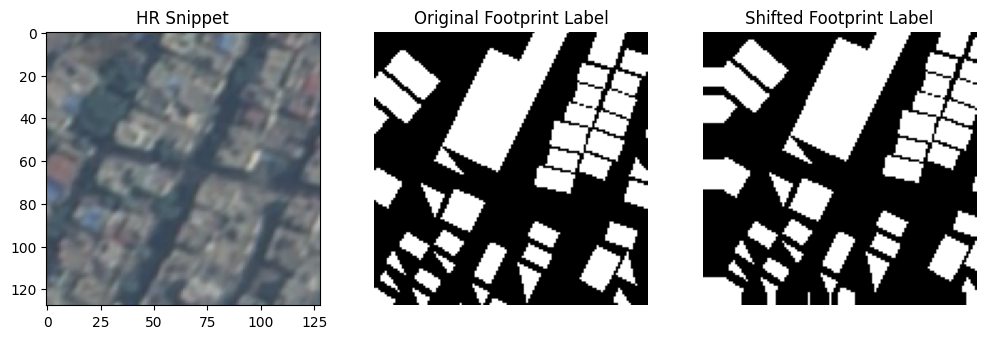

In [ ]:
index = 3999
hr_sample = hr_snippets[index]
bf_sample = bf_snippets[index]  # Original footprint
shifted_label = shifted_bf_snippets[index]  # Shifted footprint
# Replace bf_snippets with the shifted images
#bf_snippets = shifted_bf_snippets #shifted is the same as bf_snippets
# Plot the original vs. shifted labels
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# HR image
if hr_sample.shape[0] >= 3:
    axes[0].imshow(hr_sample[:3].transpose(1, 2, 0))  # RGB format
else:
    axes[0].imshow(hr_sample[0], cmap='gray')
axes[0].set_title("HR Snippet")
axes[0].axis("on")

# Original label
axes[1].imshow(bf_sample[0], cmap="gray")
axes[1].set_title("Original Footprint Label")
axes[1].axis("off")

# Shifted label
axes[2].imshow(shifted_label[0], cmap="gray")
axes[2].set_title("Shifted Footprint Label")
axes[2].axis("off")

plt.show()

array index:

In [ ]:
array_required=[2999,3000,3020,1700,2600,562,36,1112,453,2998,400,4000,3200,2700,2200,52,411,2232,2077,2067,2062,2000,2002,2003,2004,2006,2005,2007,2008,2011,2012,2013,2014,2015,2017,3030,3031,3033,3043,3059,3065,3066,3077,3080,3087,3090,3093,3094,3096,3098,3099,3100,3103,3106,3108,3011,3012,3014,3015,3018,3027,3029,3033,3036,3037,3039,3043,3045,3047,3053,3054,3058,3063,3064,3069,3070,3083,3090,3096,3098,3103,3106,3112,3457,3461,3468,3999]
print(len(array_required)+1)

88


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# hr_snippets shape: (n_samples, bands, 128, 128)
# bf_snippets shape: (n_samples, mask_channels, 128, 128)
#image_channels = 3 and masks are single channel.

X = hr_snippets.transpose(0, 2, 3, 1)  # Now shape: (n_samples, 128, 128, 3)

# Convert the building footprint masks similarly.
# If bf_snippets is single channel (but stored as (n_samples, 1, 128, 128)):
Y = shifted_bf_snippets.transpose(0, 2, 3, 1)  # Now shape: (n_samples, 128, 128, 1)

# Optionally, convert data type and normalize inputs if not done already:
X = X.astype(np.float32) / 255.0
Y = Y.astype(np.float32)  # Masks should be binary (0 or 1)

# -------------------------------
# Split into training and validation sets:
# Let's assume total samples = 4200 and use 80% for training, 20% for validation.
# -------------------------------
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# -------------------------------
# Build the U-Net Model
# -------------------------------
image_width = 128
image_height = 128
image_channels = 3

inputs = tf.keras.layers.Input(shape=(image_width, image_height, image_channels))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Dropout(0.2)(u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Dropout(0.2)(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Dropout(0.1)(u8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Dropout(0.1)(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# -------------------------------
# Train the model for 30 epochs:
# -------------------------------
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=1, batch_size=16)

# After training, print the final loss and accuracy metrics:
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\nFinal Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_acc)


KeyboardInterrupt: 

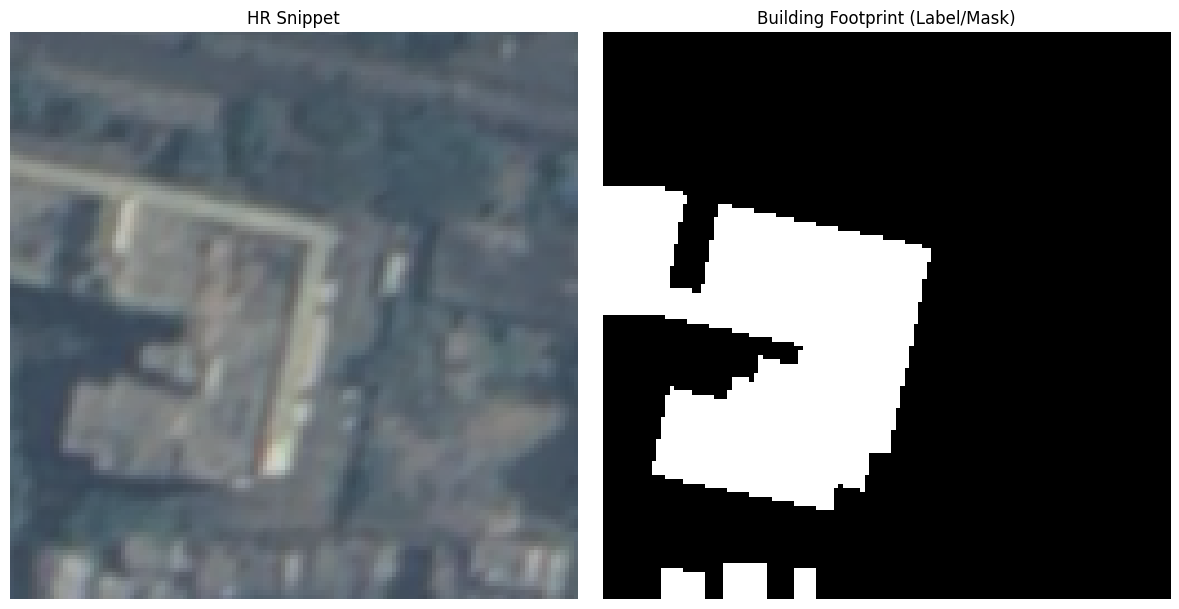

In [ ]:
import matplotlib.pyplot as plt

# Define the index for the snippet you want to display
index = 2999

# ----------------------------
# Process the HR snippet
# ----------------------------
# Extract the HR snippet from the hr_snippets array
hr_img = hr_snippets[index]  # Expected shape: (bands, 128, 128)

# If the image has 3 or more channels, assume the first 3 are RGB
if hr_img.shape[0] >= 3:
    hr_disp = hr_img[:3].transpose(1, 2, 0)  # Convert from (bands, 128, 128) to (128, 128, 3)
else:
    # For a single channel image, use a grayscale colormap
    hr_disp = hr_img[0]

# ----------------------------
# Process the Building Footprint snippet (Label/Mask)
# ----------------------------
# Extract the building footprint snippet (mask) from the bf_snippets array
bf_img = shifted_bf_snippets[index]  # Expected shape: (mask_channels, 128, 128)

# If the mask is single channel, display as grayscale;
# if it has multiple channels, assume first 3 channels represent an RGB mask.
if bf_img.shape[0] == 1:
    bf_disp = bf_img[0]
else:
    bf_disp = bf_img[:3].transpose(1, 2, 0)

# ----------------------------
# Plot the HR snippet and the corresponding label/mask side by side
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot HR snippet
axes[0].imshow(hr_disp)
axes[0].set_title("HR Snippet")
axes[0].axis('off')

# Plot Building Footprint (Label/Mask)
# Use grayscale for mask visualization if single channel
if bf_img.shape[0] == 1:
    axes[1].imshow(bf_disp, cmap='gray')
else:
    axes[1].imshow(bf_disp)
axes[1].set_title("Building Footprint (Label/Mask)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# The array of selected indices
array_required=[2999,3000,3020,1700,2600,562,36,1112,453,2998,400,4000,3200,2700,2200,52,411,2232,2077,2067,2062,2000,2002,2003,2004,2006,2005,2007,2008,2011,2012,2013,2014,2015,2017,3030,3031,3033,3043,3059,3065,3066,3077,3080,3087,3090,3093,3094,3096,3098,3099,3100,3103,3106,3108,3011,3012,3014,3015,3018,3027,3029,3033,3036,3037,3039,3043,3045,3047,3053,3054,3058,3063,3064,3069,3070,3083,3090,3096,3098,3103,3106,3112,3457,3461,3468,3999]

# Select the HR and BF snippets based on the given indices
selected_hr = [hr_snippets[i] for i in array_required]
selected_bf = [shifted_bf_snippets[i] for i in array_required]

# Convert to NumPy arrays for training (ensure correct shape)
X_train = np.array(selected_hr)  # Shape: (n_samples, 128, 128, 3)
Y_train = np.array(selected_bf)  # Shape: (n_samples, 128, 128, 1)

# Optionally, normalize data (if not already done)
X_train = X_train.astype(np.float32) / 255.0
Y_train = Y_train.astype(np.float32)

# Now you can use X_train and Y_train to train the U-Net model.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 16)     │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 32)     │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 64)     │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 1,757,825 (6.71 MB)

 Trainable params: 1,757,825 (6.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7183 - loss: 0.6191
Epoch 1: val_loss improved from inf to 0.57368, saving model to best_model.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7183 - loss: 0.6190 - val_accuracy: 0.7211 - val_loss: 0.5737
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7184 - loss: 0.5923
Epoch 2: val_loss did not improve from 0.57368
215/215 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.7184 - loss: 0.5923 - val_accuracy: 0.7211 - val_loss: 0.5922
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7215 - loss: 0.5926
Epoch 3: val_loss did not improve from 0.57368
215/215 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.7215 - loss: 0.5926 - val_accuracy: 0.7211 - val_loss: 0.5922
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7226 - loss: 0.5914
Epoch 4: val_loss did not improve from 0.57368
215/215 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.7226 - loss: 0.5914 - val_ac

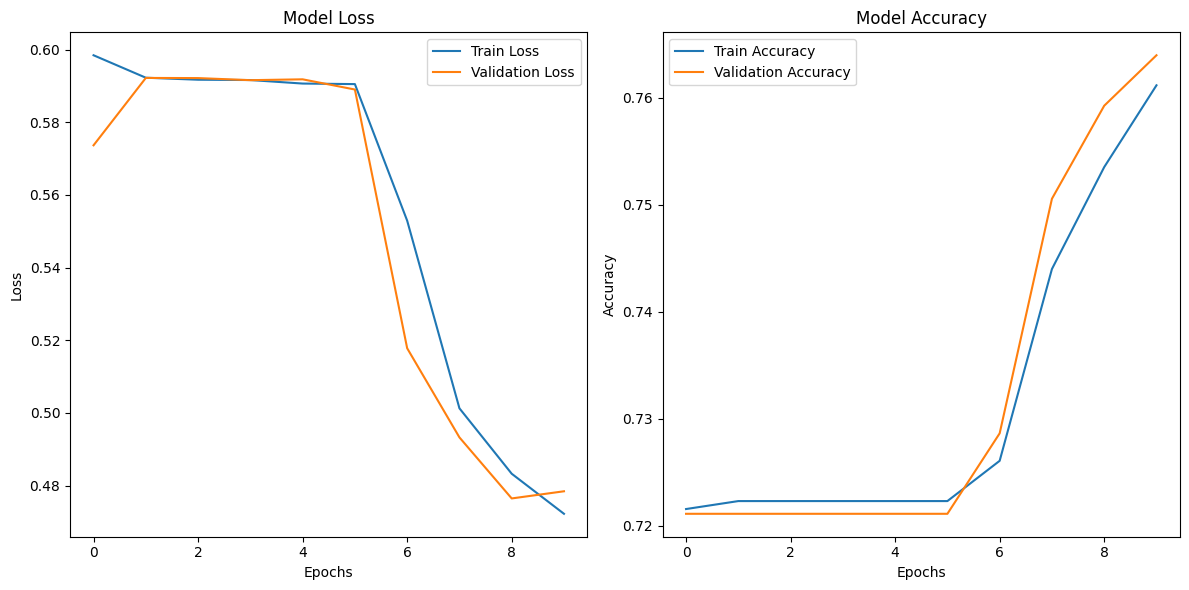

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint  # Importing the ModelCheckpoint callback

# -------------------------------
# Assume your snippet arrays are loaded:
# hr_snippets shape: (n_samples, bands, 128, 128)
# bf_snippets shape: (n_samples, mask_channels, 128, 128)
# For our U-Net, we assume image_channels = 3 and masks are single channel.
# -------------------------------

# Convert the HR images to (n_samples, 128, 128, 3)
X = hr_snippets.transpose(0, 2, 3, 1)  # Now shape: (n_samples, 128, 128, 3)

# Convert the building footprint masks similarly.
# If bf_snippets is single channel (but stored as (n_samples, 1, 128, 128)):
Y = shifted_bf_snippets.transpose(0, 2, 3, 1)  # Now shape: (n_samples, 128, 128, 1)

# Optionally, convert data type and normalize inputs if not done already:
X = X.astype(np.float32) / 255.0
Y = Y.astype(np.float32)  # Masks should be binary (0 or 1)

# -------------------------------
# Split into training and validation sets:
# Let's assume total samples = 4200 and use 80% for training, 20% for validation.
# -------------------------------
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# -------------------------------
# Build the U-Net Model
# -------------------------------
image_width = 128
image_height = 128
image_channels = 3

inputs = tf.keras.layers.Input(shape=(image_width, image_height, image_channels))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Dropout(0.2)(u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Dropout(0.2)(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Dropout(0.1)(u8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Dropout(0.1)(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# -------------------------------
# Define ModelCheckpoint callback to save the best model
# -------------------------------
checkpoint_callback = ModelCheckpoint('best_model.keras',
                                      monitor='val_loss',  # Monitor validation loss
                                      save_best_only=True,  # Save only the best model
                                      save_weights_only=False,  # Save the entire model, not just weights
                                      mode='min',  # Minimize the validation loss
                                      verbose=1)  # Show messages when saving the model

# Train the model with the checkpoint callback
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=10, batch_size=16, callbacks=[checkpoint_callback])

# After training, print the final loss and accuracy metrics:
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\nFinal Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_acc)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Enable unsafe deserialization (only if you trust the model source)
tf.keras.config.enable_unsafe_deserialization()

# Load the saved model
model = load_model('best_model.keras')

# Print model summary to check if the model was loaded correctly
model.summary()

# Recompile the model (to avoid issues with loss and optimizer state)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define additional training parameters
additional_epochs = 30
initial_epoch = 10  # Start training from the 10th epoch

# Continue training
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=initial_epoch + additional_epochs,  # Total epochs after resuming
    batch_size=16,
    initial_epoch=initial_epoch  # Resume from epoch 10
)

# Extract updated metrics after training
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\nUpdated Training Loss:", final_train_loss)
print("Updated Training Accuracy:", final_train_acc)
print("Updated Validation Loss:", final_val_loss)
print("Updated Validation Accuracy:", final_val_acc)

# Save the model after further training
model.save("best_model_updated.keras")



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 16)   │              0 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 16)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7      

 Total params: 5,273,477 (20.12 MB)

 Trainable params: 1,757,825 (6.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,515,652 (13.41 MB)

Epoch 11/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 603s 3s/step - accuracy: 0.7879 - loss: 0.4302 - val_accuracy: 0.7779 - val_loss: 0.4568
Epoch 12/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.7897 - loss: 0.4247 - val_accuracy: 0.7722 - val_loss: 0.4867
Epoch 13/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - accuracy: 0.7947 - loss: 0.4166 - val_accuracy: 0.7785 - val_loss: 0.4550
Epoch 14/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.7970 - loss: 0.4131 - val_accuracy: 0.7731 - val_loss: 0.5073
Epoch 15/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.7989 - loss: 0.4091 - val_accuracy: 0.7778 - val_loss: 0.4576
Epoch 16/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.8075 - loss: 0.3949 - val_accuracy: 0.7788 - val_loss: 0.4719
Epoch 17/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.8080 - loss: 0.3935 - val_accuracy: 0.7710 - val_loss: 0.4929
Epoch 18/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.8126 - loss: 0.3839 - 

KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Enable unsafe deserialization (only if you trust the source)
tf.keras.config.enable_unsafe_deserialization()

# Define the folder path inside Google Drive
drive_folder = "/content/drive/MyDrive/U-Net_Model"

# Create the folder if it doesn't exist
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

# Define the model path
model_path = os.path.join(drive_folder, "best_model.h5")

# Load the model from the .keras file
model = load_model("/content/best_model.keras")

# Save it as .h5 format
model.save(model_path)

print(f"Model successfully saved at: {model_path}")


Model successfully saved at: /content/drive/MyDrive/U-Net_Model/best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


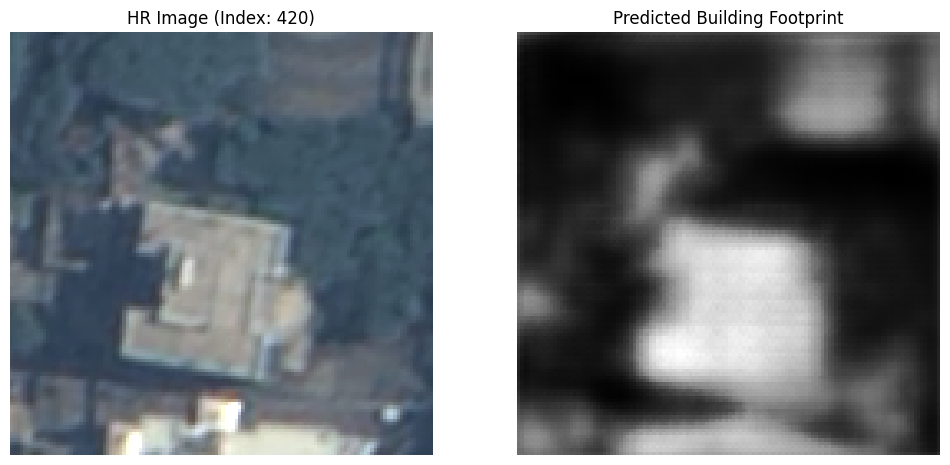

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model from .h5 file
model_path = '/content/drive/MyDrive/U-Net_Model/best_model.h5'
model = load_model(model_path)

index = 420
hr_snippet = hr_snippets[index]  # Get the HR image snippet at the specified index

# Preprocess the HR snippet (reshape if needed, normalize if necessary)
# Assuming HR snippet is (bands, height, width), so we need to reshape it for the model input
hr_snippet = hr_snippet.transpose(1, 2, 0)  # Change shape to (height, width, bands) if needed
hr_snippet = np.expand_dims(hr_snippet, axis=0)  # Add batch dimension (1, height, width, bands)

# Normalize if necessary (e.g., model expects values between 0 and 1)
hr_snippet = hr_snippet.astype(np.float32) / 255.0  # Example normalization

# Predict using the model
prediction = model.predict(hr_snippet)

# Display the HR image and the predicted building footprint
plt.figure(figsize=(12, 6))

# Display the HR image
plt.subplot(1, 2, 1)
plt.imshow(hr_snippets[index].transpose(1, 2, 0))  # Show original HR snippet (adjust for bands)
plt.title("HR Image (Index: {})".format(index))
plt.axis('off')

# Display the predicted building footprint
plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap='gray')  # Assuming binary output (single channel)
plt.title("Predicted Building Footprint")
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


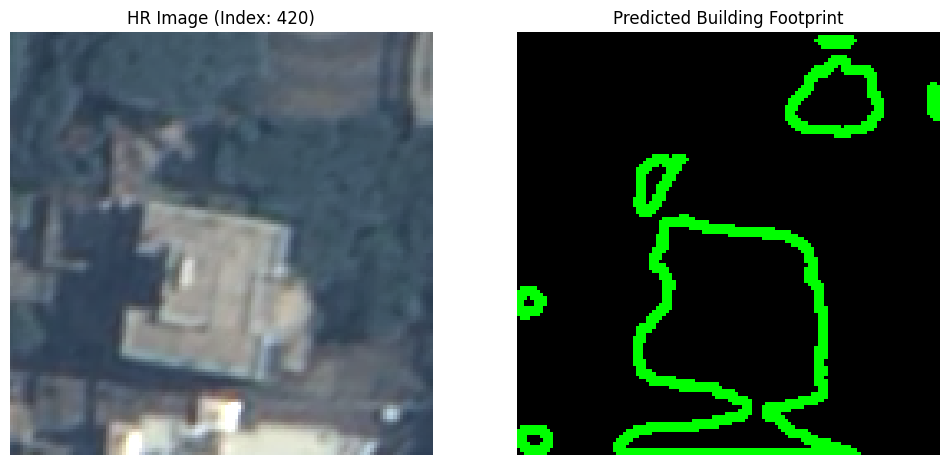

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Load the saved model from .h5 file
model_path = '/content/drive/MyDrive/U-Net_Model/best_model.h5'
model = load_model(model_path)

index = 420
hr_snippet = hr_snippets[index]  # Get the HR image snippet at the specified index

# Preprocess the HR snippet (reshape if needed, normalize if necessary)
hr_snippet = hr_snippet.transpose(1, 2, 0)  # Change shape to (height, width, bands) if needed
hr_snippet = np.expand_dims(hr_snippet, axis=0)  # Add batch dimension (1, height, width, bands)

# Normalize if necessary (e.g., model expects values between 0 and 1)
hr_snippet = hr_snippet.astype(np.float32) / 255.0  # Example normalization

# Predict using the model
prediction = model.predict(hr_snippet)

# Convert prediction to binary mask (threshold the output)
binary_prediction = (prediction[0, :, :, 0] > 0.42).astype(np.uint8)

# Find contours in the binary prediction
contours, _ = cv2.findContours(binary_prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank 3-channel image to draw the contours on (RGB format)
contour_image = np.zeros((binary_prediction.shape[0], binary_prediction.shape[1], 3), dtype=np.uint8)

# Draw contours on the contour_image (green border for the polygons)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color for contours, thickness 2

# Display the HR image and the predicted building footprint with borders
plt.figure(figsize=(12, 6))

# Display the HR image
plt.subplot(1, 2, 1)
plt.imshow(hr_snippets[index].transpose(1, 2, 0))  # Show original HR snippet (adjust for bands)
plt.title("HR Image (Index: {})".format(index))
plt.axis('off')

# Display the predicted building footprint with borders
plt.subplot(1, 2, 2)
plt.imshow(contour_image)  # Show the image with drawn contours (polygons)
plt.title("Predicted Building Footprint")
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


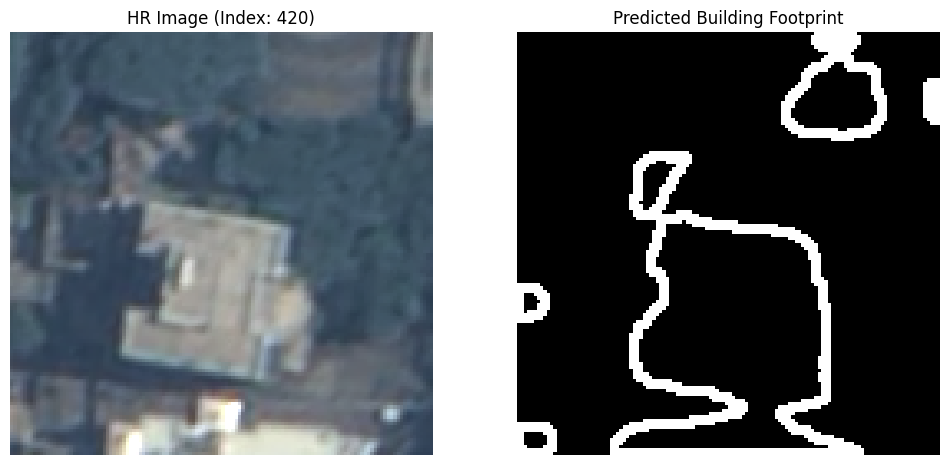

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Load the saved model from .h5 file
model_path = '/content/drive/MyDrive/U-Net_Model/best_model.h5'
model = load_model(model_path)

index = 420
hr_snippet = hr_snippets[index]  # Get the HR image snippet at the specified index

# Preprocess the HR snippet (reshape if needed, normalize if necessary)
hr_snippet = hr_snippet.transpose(1, 2, 0)  # Change shape to (height, width, bands) if needed
hr_snippet = np.expand_dims(hr_snippet, axis=0)  # Add batch dimension (1, height, width, bands)

# Normalize if necessary (e.g., model expects values between 0 and 1)
hr_snippet = hr_snippet.astype(np.float32) / 255.0  # Example normalization

# Predict using the model
prediction = model.predict(hr_snippet)

# Convert prediction to binary mask (threshold the output)
binary_prediction = (prediction[0, :, :, 0] > 0.42).astype(np.uint8)

# Optional: Apply morphological operations to clean up the mask (e.g., dilation to fill gaps)
kernel = np.ones((3, 3), np.uint8)  # Create a kernel for morphological operations
binary_prediction = cv2.dilate(binary_prediction, kernel, iterations=1)  # Apply dilation

# Find contours in the binary prediction
contours, _ = cv2.findContours(binary_prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank 3-channel image to draw the contours on (RGB format)
contour_image = np.zeros((binary_prediction.shape[0], binary_prediction.shape[1], 3), dtype=np.uint8)

# Draw contours on the contour_image (white border for the polygons)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)  # White color for contours, thickness 2

# Display the HR image and the predicted building footprint with borders
plt.figure(figsize=(12, 6))

# Display the HR image
plt.subplot(1, 2, 1)
plt.imshow(hr_snippets[index].transpose(1, 2, 0))  # Show original HR snippet (adjust for bands)
plt.title("HR Image (Index: {})".format(index))
plt.axis('off')

# Display the predicted building footprint with white borders
plt.subplot(1, 2, 2)
plt.imshow(contour_image)  # Show the image with drawn contours (polygons)
plt.title("Predicted Building Footprint")
plt.axis('off')

plt.show()


 enhanced accuracy by improving thresholding, applying more effective morphological operations, and refining contour extraction.

Improvements:
Adaptive Thresholding – Instead of a fixed threshold, we use Otsu’s method to dynamically determine the best threshold value.
Morphological Closing – To remove noise and small gaps within building footprints.
Contour Approximation – To smooth the detected contours.
Overlay Contours on the Original Mask – Instead of extracting just edges, this ensures a more accurate representation.

---



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


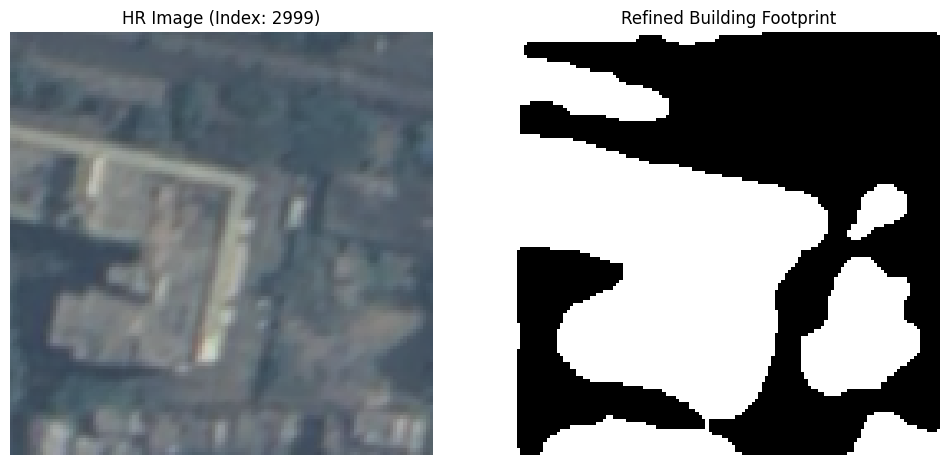

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Load the U-Net model
model_path = '/content/drive/MyDrive/U-Net_Model/best_model.h5'
model = load_model(model_path)

index = 2999
hr_snippet = hr_snippets[index]  # Get the HR image snippet at the specified index

# Preprocess the HR snippet
hr_snippet = hr_snippet.transpose(1, 2, 0)  # Ensure shape is (H, W, C)
hr_snippet = np.expand_dims(hr_snippet, axis=0)  # Add batch dimension
hr_snippet = hr_snippet.astype(np.float32) / 255.0  # Normalize

# Predict building footprint
prediction = model.predict(hr_snippet)[0, :, :, 0]

# Convert prediction to binary mask using an optimal threshold
binary_prediction = (prediction > 0.25).astype(np.uint8) * 255  # Keeping threshold at 0.5 for now

# Apply a slight morphological **closing** to fix minor gaps (not too aggressive)
kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.morphologyEx(binary_prediction, cv2.MORPH_CLOSE, kernel, iterations=1)

# **Ensure buildings are WHITE and background is BLACK**
# Since white is 255 and black is 0, we keep the current mask as is.

# Display results
plt.figure(figsize=(12, 6))

# HR Image
plt.subplot(1, 2, 1)
plt.imshow(hr_snippets[index].transpose(1, 2, 0))
plt.title("HR Image (Index: {})".format(index))
plt.axis('off')

# Improved Mask with White Buildings, Black Background
plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title("Refined Building Footprint")
plt.axis('off')

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio  # For reading .tif files
from tensorflow.keras.models import load_model

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/U-Net_Model/best_model.h5"
model = load_model(model_path)

# Load the high-resolution .tif image
tif_path = "/content/drive/MyDrive/Bang_Part/bang_rastor_clipped.tif"
with rasterio.open(tif_path) as dataset:
    hr_image = dataset.read()  # Read as NumPy array (Bands, H, W)
    transform = dataset.transform  # Preserve geospatial info

# Convert from (Bands, H, W) → (H, W, Bands)
hr_image = np.transpose(hr_image, (1, 2, 0))

# Normalize and add batch dimension
hr_input = hr_image.astype(np.float32) / 255.0
hr_input = np.expand_dims(hr_input, axis=0)  # Shape: (1, H, W, Bands)

# Model prediction
prediction = model.predict(hr_input)[0, :, :, 0]

# Convert to binary mask (thresholding)
binary_mask = (prediction > 0.5).astype(np.uint8) * 255

# Apply morphological closing to refine results
kernel = np.ones((3, 3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours of buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw outlines (black background)
outline_image = np.zeros_like(binary_mask)

# Draw building outlines (White contours, thickness 2)
cv2.drawContours(outline_image, contours, -1, (255), thickness=2)

# Save the outlined image
output_path = "/content/building_outlines.png"
cv2.imwrite(output_path, outline_image)

# Display results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(hr_image)
plt.title("Original HR Image")
plt.axis("off")

# Building Outlines
plt.subplot(1, 2, 2)
plt.imshow(outline_image, cmap="gray")
plt.title("Predicted Building Outlines")
plt.axis("off")

plt.show()

print(f"Building outlines saved at: {output_path}")


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(1, 13113, 5496, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


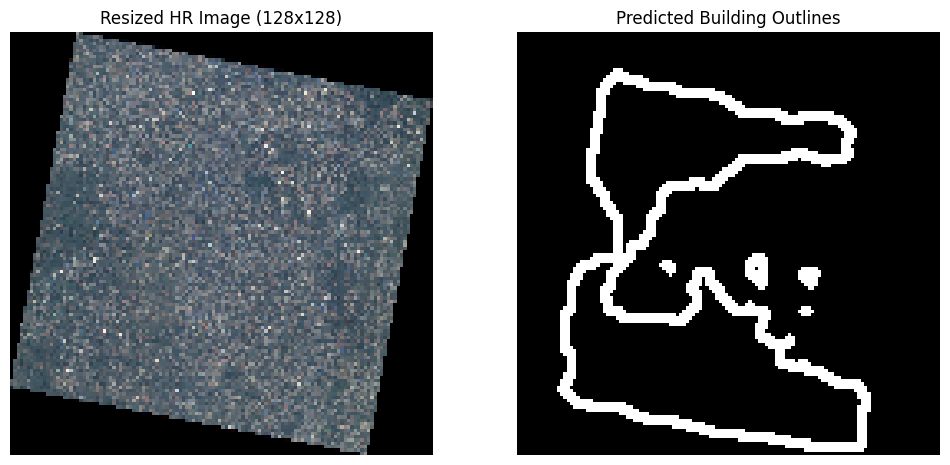

Building outlines saved at: /content/building_outlines.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio  # For reading .tif files
from tensorflow.keras.models import load_model

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/U-Net_Model/best_model.h5"
model = load_model(model_path)

# Load the high-resolution .tif image
tif_path = "/content/drive/MyDrive/Bang_Part/Bang_51021_34321_panshp.tif"
with rasterio.open(tif_path) as dataset:
    hr_image = dataset.read()  # Read as NumPy array (Bands, H, W)
    transform = dataset.transform  # Preserve geospatial info

# Convert from (Bands, H, W) → (H, W, Bands)
hr_image = np.transpose(hr_image, (1, 2, 0))

# Resize the image to (128, 128) to match the model's input shape
resized_image = cv2.resize(hr_image, (128, 128))

# Normalize and add batch dimension
hr_input = resized_image.astype(np.float32) / 255.0
hr_input = np.expand_dims(hr_input, axis=0)  # Shape: (1, 128, 128, 3)

# Model prediction
prediction = model.predict(hr_input)[0, :, :, 0]  # Model output shape: (128, 128, 1)

# Convert to binary mask (thresholding)
binary_mask = (prediction > 0.5).astype(np.uint8) * 255

# Apply morphological closing to refine results
kernel = np.ones((3, 3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours of buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw outlines (black background)
outline_image = np.zeros_like(binary_mask)

# Draw building outlines (White contours, thickness 2)
cv2.drawContours(outline_image, contours, -1, (255), thickness=2)

# Save the outlined image
output_path = "/content/building_outlines.png"
cv2.imwrite(output_path, outline_image)

# Display results
plt.figure(figsize=(12, 6))

# Original Image (Resized for display)
plt.subplot(1, 2, 1)
plt.imshow(resized_image)
plt.title("Resized HR Image (128x128)")
plt.axis("off")

# Building Outlines
plt.subplot(1, 2, 2)
plt.imshow(outline_image, cmap="gray")
plt.title("Predicted Building Outlines")
plt.axis("off")

plt.show()

print(f"Building outlines saved at: {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Prediction shape: (1, 128, 128, 1)


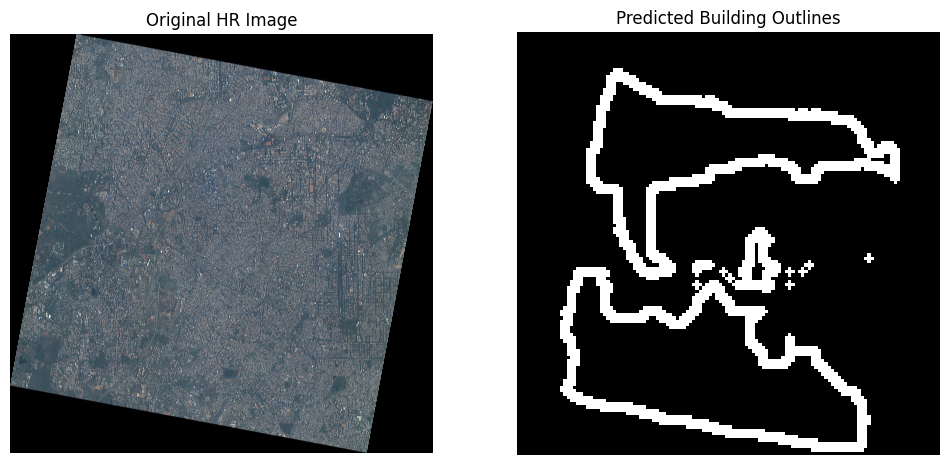

Building outlines saved at: /content/building_outlines.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
from tensorflow.keras.models import load_model

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/U-Net_Model/best_model.h5"
model = load_model(model_path)

# Load the high-resolution .tif image
tif_path = "/content/drive/MyDrive/Bang_Part/Bang_51021_34321_panshp.tif"
with rasterio.open(tif_path) as dataset:
    hr_image = dataset.read()  # Read as NumPy array (Bands, H, W)
    transform = dataset.transform  # Preserve geospatial info

# Convert from (Bands, H, W) → (H, W, Bands)
hr_image = np.transpose(hr_image, (1, 2, 0))

# Function to pad the image to maintain aspect ratio
def pad_image(image, target_height, target_width):
    height, width, _ = image.shape
    scale = min(target_height / height, target_width / width)

    new_height = int(height * scale)
    new_width = int(width * scale)

    resized_image = cv2.resize(image, (new_width, new_height))

    # Create a target canvas with the desired dimensions
    padded_image = np.ones((target_height, target_width, 3), dtype=np.float32) * 255  # White padding

    # Calculate the offset to center the resized image
    offset_y = (target_height - new_height) // 2
    offset_x = (target_width - new_width) // 2

    # Place the resized image onto the padded canvas
    padded_image[offset_y:offset_y + new_height, offset_x:offset_x + new_width, :] = resized_image

    return padded_image

# Pad the image to maintain aspect ratio and resize to (128, 128)
hr_input = pad_image(hr_image, 128, 128)

# Normalize and add batch dimension
hr_input = hr_input.astype(np.float32) / 255.0
hr_input = np.expand_dims(hr_input, axis=0)  # Shape: (1, 128, 128, 3)

# Model prediction
prediction = model.predict(hr_input)

# Check the shape of the prediction
print(f"Prediction shape: {prediction.shape}")

# Convert to binary mask (thresholding)
binary_mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255

# Apply morphological closing to refine results
kernel = np.ones((3, 3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours of buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw outlines (black background)
outline_image = np.zeros_like(binary_mask)

# Draw building outlines (White contours, thickness 2)
cv2.drawContours(outline_image, contours, -1, (255), thickness=2)

# Save the outlined image
output_path = "/content/building_outlines.png"
cv2.imwrite(output_path, outline_image)

# Display results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(hr_image)
plt.title("Original HR Image")
plt.axis("off")

# Building Outlines
plt.subplot(1, 2, 2)
plt.imshow(outline_image, cmap="gray")
plt.title("Predicted Building Outlines")
plt.axis("off")

plt.show()

print(f"Building outlines saved at: {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


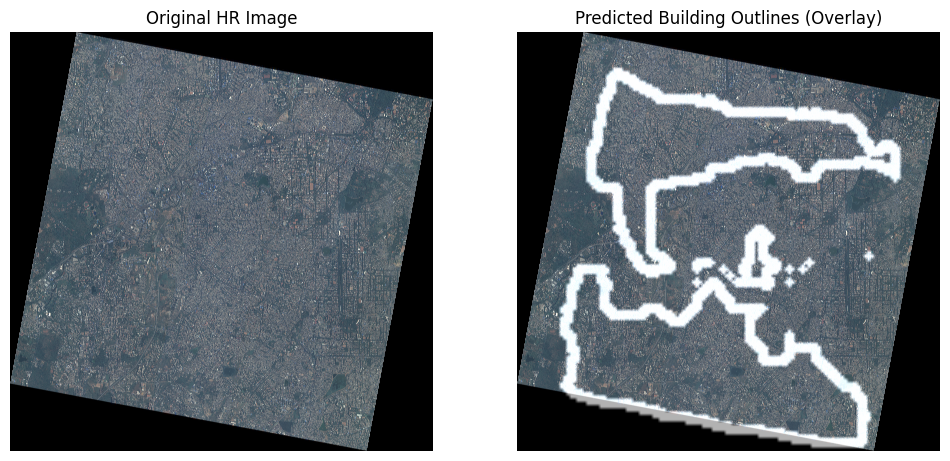

Building outlines overlay saved at: /content/building_outlines_overlay.tif


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio
from tensorflow.keras.models import load_model

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/U-Net_Model/best_model.h5"
model = load_model(model_path)

# Load the high-resolution .tif image
tif_path = "/content/drive/MyDrive/Bang_Part/Bang_51021_34321_panshp.tif"
with rasterio.open(tif_path) as dataset:
    hr_image = dataset.read()  # Read as NumPy array (Bands, H, W)
    transform = dataset.transform  # Preserve geospatial info
    meta = dataset.meta  # Get metadata for saving

# Convert from (Bands, H, W) → (H, W, Bands)
hr_image = np.transpose(hr_image, (1, 2, 0))

# Function to pad the image to maintain aspect ratio
def pad_image(image, target_height, target_width):
    height, width, _ = image.shape
    scale = min(target_height / height, target_width / width)

    new_height = int(height * scale)
    new_width = int(width * scale)

    resized_image = cv2.resize(image, (new_width, new_height))

    # Create a target canvas with the desired dimensions
    padded_image = np.ones((target_height, target_width, 3), dtype=np.float32) * 255  # White padding

    # Calculate the offset to center the resized image
    offset_y = (target_height - new_height) // 2
    offset_x = (target_width - new_width) // 2

    # Place the resized image onto the padded canvas
    padded_image[offset_y:offset_y + new_height, offset_x:offset_x + new_width, :] = resized_image

    return padded_image

# Pad the image to maintain aspect ratio and resize to (128, 128)
hr_input = pad_image(hr_image, 128, 128)

# Normalize and add batch dimension
hr_input = hr_input.astype(np.float32) / 255.0
hr_input = np.expand_dims(hr_input, axis=0)  # Shape: (1, 128, 128, 3)

# Model prediction
prediction = model.predict(hr_input)

# Convert to binary mask (thresholding)
binary_mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255

# Apply morphological closing to refine results
kernel = np.ones((3, 3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours of buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw outlines (black background)
outline_image = np.zeros_like(binary_mask)

# Draw building outlines (White contours, thickness 2)
cv2.drawContours(outline_image, contours, -1, (255), thickness=2)

# Resize the outline_image back to the original image size using padding
outline_image_resized = cv2.resize(outline_image, (hr_image.shape[1], hr_image.shape[0]))

# Overlay the outlines on the original image (with some transparency)
# Convert the original image to RGB if it has multiple bands (for visualization)
if hr_image.shape[2] == 1:
    hr_image_rgb = cv2.cvtColor(hr_image, cv2.COLOR_GRAY2RGB)
else:
    hr_image_rgb = hr_image

# Combine the outline on the original image (use a weighted overlay)
overlay_image = cv2.addWeighted(hr_image_rgb, 1, np.repeat(outline_image_resized[:, :, np.newaxis], 3, axis=2), 0.7, 0)

# Save the result as a .tif file (keeping the original geospatial info)
output_path = "/content/building_outlines_overlay.tif"
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(np.transpose(overlay_image, (2, 0, 1)))  # Save as (Bands, H, W)

# Display results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(hr_image)
plt.title("Original HR Image")
plt.axis("off")

# Overlayed Image with Building Outlines
plt.subplot(1, 2, 2)
plt.imshow(overlay_image)
plt.title("Predicted Building Outlines")
plt.axis("off")

plt.show()

print(f"Building outlines overlay saved at: {output_path}")
